<h1><center>Bayesian Data Analysis project report</center></h1>

<img src="http://icopartners.com/newblog/wp-content/uploads/2018/02/header.png">

<h1><center>Luxury Shirts Inc.</center></h1>


 <img src="https://drive.google.com/uc?export=download&id=128Kg294NTDaTgx7orbM342LVfqA3bh4S"> 

* First product (the shirt pictured above) to launch on Kickstarter (https://www.kickstarter.com/about?ref=global-footer)
* Price point for the shirt is 200€
* The goal of the campaign is to gather 20 000€ to cover production and other expenses

#### How likely is it that the project will be successfull or should there be some changes to the pricing and/or goal?

## Introduction

The goal of this project and report is to analyze whether the presented business case seems plausible based on historical Kickstarter project data.

Kickstarter is a platform where users can submit different projects online and gather funding from other Kickstarter users. The main success metric for the projects is whether it managed to pledge more money that the goal set for the project. If the project does not meet or exceed the goal, all the pledged funding will be cancleled and the project labeled as unsuccessful.

In this particular analysis problem, we will analyze different choices for the parameters related to the project to have a high probability of success and seeing whether this project fits in that predicted requirement.

This notebook will present the following:
* Description of the data and analysis problem
* Description of the used model and comparison to other tested models
* Discussion about used priors
* Technical implementation of the model and running it
* Convergence analysis and predictive checking
* Conclusion based on the results
* Discussion about potential improvements

## Description of data and analysis problem

The data used for this analysis is historical Kickstarter project data downloaded from Kaggle (https://www.kaggle.com/kemical/kickstarter-projects).

The main used data points per project are:
* Success (boolean)
* Goal of the project (USD)
* Amount of money pledged for the project (USD)
* Amount of backers (int)
* Category of the project

The data points used in a certain model will change the interpretation of feasibility regarding our project, but all results should help guide the evaluation.

The data set has over 370 000 data points, but we have cut it down based on some thresholds and also resampled it for more efficient computation. The success metric has also been converted to be binary instead of containing multiple values (all canceled ones removed for example).

If you want to run the model yourself, you should download the zip file from the foillowing link and extract the csv file as "projects.csv": https://www.kaggle.com/kemical/kickstarter-projects/downloads/kickstarter-projects.zip/3

In the following code we will transform the data into useful form and display the first few rows of the data to get a grasp how it looks like. How the data is used in our models will be discussed in the next section.

In [354]:
#Import librararies that will be used throughout this notebook
import pystan
from pystan import StanModel
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from psis import psisloo
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, KFold
from sklearn.utils import resample

In [439]:
projects = pd.read_csv("projects.csv", header=None)
pm = np.array(projects) #All project data
pm = np.delete(pm, (0), axis=0) #Delete top row
pm = np.delete(pm, (0,1,2,4,5,7,11,12,13,14,15,16), axis=1) #Delete non needed columns


success_idx = pm[:,3] == "successful" #Tuple of all indexes that are successful
failed_idx = pm[:,3] == "failed" #Tuple of all indexes that failed

#Remove all rows where the end result is not successful or failed
remove_idx = np.where(np.logical_or(success_idx,failed_idx)==False)
pm = np.delete(pm, remove_idx, axis=0)

#Find new indexes for success and fail cases
success_idx = pm[:,3] == "successful"
failed_idx = pm[:,3] == "failed"

#Replace failed values with 0, success with 0 and convert whole matrix to numeric values
pm[success_idx,3] = 1
pm[failed_idx,3] = 0

#Remove all rows where the data points are below a threshold
remove_idx = np.where(pm[:,4].astype(int) < 10) #Remove all projects with backer count less than 20
pm = np.delete(pm, remove_idx, axis=0)

category_idx = np.where((pm[:,0] == "Fashion") | (pm[:,0] == 'Apparel'))
pm_cat = pm[category_idx]

success_idx = pm_cat[:,3] == 1
pm_suc = pm_cat[success_idx]

suc_mean_back = np.mean(pm_suc[:,4].astype(float))
suc_mean_goal = np.mean(pm_suc[:,1].astype(float))
suc_mean_pled = np.mean(pm_suc[:,2].astype(float))


pm = resample(pm,n_samples=100,random_state=0) #Resample data used in fitting into model
pm_cat = resample(pm_cat,n_samples=100,random_state=0)

pd.DataFrame(pm).to_csv("sanitized.csv",header=False, index=False)
sanitized = pd.read_csv("sanitized.csv", header=None, names=["Category","Goal (USD)","Pledged (USD)","Success (bool)","Backers (int)"])
display(HTML(sanitized.head(50).to_html(max_rows=50)))

/Users/juliushietala/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Category,Goal (USD),Pledged (USD),Success (bool),Backers (int)
0,Film & Video,90000,24047.00,0,264
1,Music,2000,2399.00,1,86
2,Music,1000,1570.00,1,30
3,Technology,30000,7825.00,0,57
4,Film & Video,5000,18360.00,1,57
5,Music,3000,3165.00,1,91
6,Film & Video,2000,2046.00,1,26
7,Theater,3800,4600.04,1,62
8,Art,50000,8593.00,0,158
9,Music,7500,10391.00,1,184


## Description of the model

Given the binary nature of the data, a binomial model is the most appropriate for this particular problem. The data points $y_i$ are binomially distributed and the model is of the form: <h3>$$y_i | θ_i ∼ Bin( n_i , θ_i ),$$</h3> 

where $θ_i$ is the probability of success for each project. The form and different variations of $θ_i$ tested during this project are discussed below. One example of models tested will be <h3>$$logit(θ_i) = a + bs + cg,$$</h3>

where $s$ (supporters) is the amount of backers of the project and $g$ (goal) is the goal of the project. To make sure that the probability $θ_i$ lies between 0 and 1, we use the logit transformation as shown above. The interesting insights we will draw from this equation is that we set a desired probability of success (80% in our case), and use the parameter values drawn from the posterior distrubution to evaluate the distribution of the desired variables (such as backer count).

In this report we will evaluate 4 different models in total and evaluate them with PSIS-LOO predictive checking:
* <h4>$logit(θ_i) = a + bs $ (i.e. how many backers should a successful project gather?)</h4>
* <h4>$logit(θ_i) = a + cg$ (i.e. what should the goal be for a successful project?)</h4>
* <h4>$logit(θ_i) = a + dp$ (i.e. how much should a successful project pledge i.e. the goal be set at?)</h4>
* <h4>$logit(θ_i) = a + bs + cg$ (i.e. how many backers should a successful project gather given our initial goal?)</h4>

where $s$ denotes the backer count, and $g$ denotes the goal of a project, and $p$ nenotes the pledged amount for a project. The values $a$, $b$, $c$, and $d$ are the parameters for different possible models.

The reason that none of the models combine the goal and pledged amounts is that we can already draw the end result (success/fail) if we know the goal and pledged amounts.

In addition to testing the four models, we will also test the models with data that belongs to the same category with our project (i.e. fashion and apparel).

## Discussion about priors

We will define some priors in the models for the parameters $b$ and $c$. These will be justified rather intuitively than based on domain experience. But in general we would expect that achieving a higher number of backers and a pledged amount correlates positively with the success of the project. Inversely, a higher goal seems like a harder thing to actually achieve and therefore making it correlate negatively with the end result. We'll use the following priors for these parameters:
* <h4>$b$ ~ $normal(1,10)$</h4>
* <h4>$c$ ~ $normal(-1,5)$</h4>
* <h4>$d$ ~ $normal(1,5)$</h4>

## Stan implementation and running

We'll implement the stan models as strings and save them as files from the python code. This workflow has proved to be the most efficient throughout the project and it also enchances readability.

#### Model 1

In [357]:
stan_content_1 = """
data {
    int N; // amount of projects
    int n[N]; //projects 

    vector [N] s; // backers
    int y[N]; // success
}

parameters {
    real a;
    real b;
}

model {
    b ~ normal(1,10);
    y ~ binomial_logit(N, a + b*s);
}

generated quantities {
  vector[N] log_lik;
  for (i in 1:N) {
    log_lik[i] = binomial_logit_lpmf(y[i] | n[i], a + b*s[i]);
  }
}
"""
stan_file_1 = open("model_1.stan", "w")
stan_file_1.write(stan_content_1)
stan_file_1.close()

#### Model 2

In [358]:
stan_content_2 = """
data {
    int N; // amount of projects
    int n[N]; //projects 

    vector [N] g; // goal
    int y[N]; // success
}

parameters {
    real a;
    real c;
}

model {
    c ~ normal(-1,5);
    y ~ binomial_logit(N, a + c*g);
}

generated quantities {
  vector[N] log_lik;
  for (i in 1:N) {
    log_lik[i] = binomial_logit_lpmf(y[i] | n[i], a + c*g[i]);
  }
}
"""
stan_file_2 = open("model_2.stan", "w")
stan_file_2.write(stan_content_2)
stan_file_2.close()

#### Model 3

In [367]:
stan_content_3 = """
data {
    int N; // amount of projects
    int n[N]; //projects 

    vector [N] p; // pledged
    int y[N]; // success
}

parameters {
    real a;
    real d;
}

model {
    d ~ normal(1,5);
    y ~ binomial_logit(N, a + d*p);
}

generated quantities {
  vector[N] log_lik;
  for (i in 1:N) {
    log_lik[i] = binomial_logit_lpmf(y[i] | n[i], a + d*p[i]);
  }
}
"""
stan_file_3 = open("model_3.stan", "w")
stan_file_3.write(stan_content_3)
stan_file_3.close()

#### Model 4

In [360]:
stan_content_4 = """
data {
    int N; // amount of projects
    int n[N]; //projects 

    vector [N] g; // goal
    vector [N] s; // backers
    int y[N]; // success
}

parameters {
    real a;
    real b;
    real c;
}

model {
    b ~ normal(1,10);
    c ~ normal(-0.5,5);
    y ~ binomial_logit(N, a + b*s + c*g);
}

generated quantities {
  vector[N] log_lik;
  for (i in 1:N) {
    log_lik[i] = binomial_logit_lpmf(y[i] | n[i], a + b*s[i] + c*g[i]);
  }
}
"""
stan_file_4 = open("model_4.stan", "w")
stan_file_4.write(stan_content_4)
stan_file_4.close()

Next, let's format the data so that we can fit it into the model

In [361]:
#All projects
g = np.asarray(pm[:,1].astype(float)) # Goal
p = np.asarray(pm[:,2].astype(float)) # Pledged
y = np.asarray(pm[:,3].astype(int)) # Success
s = np.asarray(pm[:,4].astype(int)) # Backers / supporters


#Fashion and apparel category
g_cat = np.asarray(pm_cat[:,1].astype(float)) # Goal
p_cat = np.asarray(pm_cat[:,2].astype(float)) # Pledged
y_cat = np.asarray(pm_cat[:,3].astype(int)) # Success
s_cat = np.asarray(pm_cat[:,4].astype(int)) # Backers / supporters

N = pm.shape[0] # Size of data
n = np.asarray(np.ones((N,1))[:,0]).astype(int) # Projects per group, always = 1

Next, let's fit the data into each model and print a summary

#### Model 1
* All data

In [362]:
data_1_all= {
    's':np.log(s),
    'y':y,
    'N': N,
    'n': n
}

model_1_all = pystan.StanModel(file='model_1.stan')
fit_1_all = model_1_all.sampling(data=data_1_all)
samples_1_all = fit_1_all.extract(permuted=True)
print(fit_1_all)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d96b445fa8445a4aba9880eabb8d9503 NOW.
/Users/juliushietala/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_d96b445fa8445a4aba9880eabb8d9503.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a            -5.62    0.02   0.46  -6.54  -5.94  -5.63  -5.31  -4.67    849   1.01
b             0.15  3.4e-3    0.1  -0.05   0.09   0.15   0.22   0.34    830   1.01
log_lik[0]   -4.66  6.1e-3   0.21   -5.1   -4.8  -4.65  -4.51  -4.29   1180   1.01
log_lik[1]   -4.94  1.9e-3   0.12  -5.18  -5.02  -4.94  -4.86  -4.71   3658    1.0
log_lik[2]   -4.82  2.8e-3   0.14  -5.11  -4.91  -4.81  -4.72  -4.57   2352    1.0
log_lik[3]   -5.12  4.8e-3   0.17  -5.46  -5.24  -5.12  -5.01   -4.8   1223   1.01
log_lik[4]   -5.09  4.2e-3   0.16   -5.4   -5.2  -5.09  -4.99   -4.8   1356   1.01
log_lik[5]   -4.88  2.0e-3   0.12  -5.13  -4.96  -4.88   -4.8  -4.65   3684    1.0
log_lik[6]   -4.95  2.0e-3   0.12  -5.19  -5.03  -4.95  -4.87  -

* Category data

In [363]:
data_1_cat= {
    's':np.log(s_cat),
    'y':y_cat,
    'N': N,
    'n': n
}

model_1_cat = pystan.StanModel(file='model_1.stan')
fit_1_cat = model_1_cat.sampling(data=data_1_cat)
samples_1_cat = fit_1_cat.extract(permuted=True)
print(fit_1_cat)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d96b445fa8445a4aba9880eabb8d9503 NOW.
/Users/juliushietala/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_d96b445fa8445a4aba9880eabb8d9503.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a            -5.72    0.02   0.51  -6.77  -6.06  -5.72  -5.39  -4.66    591   1.01
b             0.18  4.3e-3   0.11  -0.04   0.11   0.18   0.25   0.38    600   1.01
log_lik[0]   -4.93  2.4e-3   0.12  -5.18  -5.01  -4.93  -4.85   -4.7   2409    1.0
log_lik[1] -6.9e-3  2.3e-5 9.0e-4-8.8e-3-7.5e-3-6.9e-3-6.3e-3-5.2e-3   1528    nan
log_lik[2]   -4.86  1.9e-3   0.12  -5.09  -4.93  -4.85  -4.78  -4.64   3649    1.0
log_lik[3] -7.5e-3  1.6e-5 8.6e-4-9.2e-3-8.0e-3-7.4e-3-6.9e-3-5.9e-3   3002    nan
log_lik[4] -6.2e-3  3.9e-5 1.1e-3-8.6e-3-6.8e-3-6.1e-3-5.5e-3-4.2e-3    767   1.01
log_lik[5]   -4.53  7.7e-3   0.24  -5.01  -4.68  -4.52  -4.36  -4.09    943   1.01
log_lik[6]   -5.17  7.8e-3   0.21  -5.59   -5.3  -5.17  -5.03  -

#### Model 2
* All data

In [364]:
data_2_all= {
    'g':np.log(g),
    'y':y,
    'N': N,
    'n': n
}

model_2_all = pystan.StanModel(file='model_2.stan')
fit_2_all = model_2_all.sampling(data=data_2_all)
samples_2_all = fit_2_all.extract(permuted=True)
print(fit_2_all)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4c2c6b9f4243b6884045886e31fa0fb7 NOW.
/Users/juliushietala/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_4c2c6b9f4243b6884045886e31fa0fb7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a            -3.25    0.02   0.73  -4.67  -3.76  -3.25  -2.72  -1.83    895    1.0
c             -0.2  2.9e-3   0.09  -0.37  -0.26   -0.2  -0.14  -0.03    909    1.0
log_lik[0]   -5.03  2.4e-3   0.13   -5.3  -5.12  -5.03  -4.94  -4.79   2932    1.0
log_lik[1]   -4.81  2.7e-3   0.13  -5.07   -4.9  -4.81  -4.72  -4.57   2265    1.0
log_lik[2]   -5.02  2.3e-3   0.13  -5.28   -5.1  -5.02  -4.92  -4.78   3084    1.0
log_lik[3]    -4.6  5.2e-3   0.18  -4.96  -4.72   -4.6  -4.48  -4.26   1175    1.0
log_lik[4]   -4.85  2.3e-3   0.12  -5.09  -4.93  -4.85  -4.76  -4.61   2757    1.0
log_lik[5]   -5.22  4.6e-3   0.18  -5.59  -5.35  -5.22  -5.09  -4.88   1593    1.0
log_lik[6]   -4.74  3.6e-3   0.14  -5.02  -4.84  -4.74  -4.65  -

* Category data

In [365]:
data_2_cat= {
    'g':np.log(g_cat),
    'y':y_cat,
    'N': N,
    'n': n
}

model_2_cat = pystan.StanModel(file='model_2.stan')
fit_2_cat = model_2_cat.sampling(data=data_2_cat)
samples_2_cat = fit_2_cat.extract(permuted=True)
print(fit_2_cat)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4c2c6b9f4243b6884045886e31fa0fb7 NOW.
/Users/juliushietala/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_4c2c6b9f4243b6884045886e31fa0fb7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a            -3.81    0.03    0.9  -5.55  -4.41  -3.78  -3.19  -2.11    684    1.0
c            -0.12  3.9e-3    0.1  -0.31  -0.19  -0.12  -0.05   0.07    684    1.0
log_lik[0]   -4.85  2.5e-3   0.12  -5.09  -4.93  -4.84  -4.77  -4.62   2383    1.0
log_lik[1] -6.4e-3  3.9e-5 1.3e-3-9.2e-3-7.2e-3-6.3e-3-5.5e-3-4.3e-3   1044    1.0
log_lik[2]   -4.85  2.5e-3   0.12  -5.09  -4.93  -4.84  -4.77  -4.62   2383    1.0
log_lik[3] -7.3e-3  1.7e-5 9.0e-4-9.2e-3-7.9e-3-7.3e-3-6.7e-3-5.7e-3   2884    nan
log_lik[4] -7.3e-3  1.7e-5 9.0e-4-9.2e-3-7.9e-3-7.3e-3-6.7e-3-5.7e-3   2884    nan
log_lik[5]   -4.95  2.8e-3   0.13   -5.2  -5.04  -4.95  -4.86   -4.7   2137    1.0
log_lik[6]   -4.71  6.1e-3   0.19   -5.1  -4.83   -4.7  -4.58  -

#### Model 3
* All data

In [368]:
data_3_all= {
    'p':np.log(p),
    'y':y,
    'N': N,
    'n': n
}

model_3_all = pystan.StanModel(file='model_3.stan')
fit_3_all = model_3_all.sampling(data=data_3_all)
samples_3_all = fit_3_all.extract(permuted=True)
print(fit_3_all)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_29cf2fb9252779f879a377ef4763cfd1 NOW.
/Users/juliushietala/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_29cf2fb9252779f879a377ef4763cfd1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a            -5.84    0.03   0.75  -7.27  -6.36  -5.85  -5.33  -4.33    694    1.0
d              0.1  3.3e-3   0.09  -0.07   0.05   0.11   0.16   0.27    685    1.0
log_lik[0]   -4.76  5.8e-3   0.19  -5.14  -4.89  -4.76  -4.63  -4.42   1045    1.0
log_lik[1]   -5.03  3.4e-3   0.14  -5.31  -5.12  -5.03  -4.93  -4.77   1688    1.0
log_lik[2]   -4.88  2.7e-3   0.13  -5.14  -4.96  -4.88  -4.78  -4.64   2230    1.0
log_lik[3]   -5.14  6.6e-3    0.2  -5.55  -5.27  -5.14   -5.0  -4.76    926    1.0
log_lik[4]    -5.0  2.8e-3   0.13  -5.26  -5.09   -5.0  -4.92  -4.76   2159    1.0
log_lik[5]   -4.81  4.4e-3   0.16  -5.14  -4.92  -4.81   -4.7  -4.52   1286    1.0
log_lik[6]   -4.99  2.5e-3   0.12  -5.24  -5.07  -4.99   -4.9  -

* Category data

In [369]:
data_3_cat= {
    'p':np.log(p_cat),
    'y':y_cat,
    'N': N,
    'n': n
}

model_3_cat = pystan.StanModel(file='model_3.stan')
fit_3_cat = model_3_cat.sampling(data=data_3_cat)
samples_3_cat = fit_3_cat.extract(permuted=True)
print(fit_3_cat)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_29cf2fb9252779f879a377ef4763cfd1 NOW.
/Users/juliushietala/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_29cf2fb9252779f879a377ef4763cfd1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a            -6.35    0.03   0.86  -8.09  -6.91  -6.35  -5.79  -4.71    644    1.0
d             0.16  3.6e-3   0.09  -0.02    0.1   0.16   0.22   0.34    641   1.01
log_lik[0]   -4.98  3.3e-3   0.13  -5.25  -5.07  -4.98  -4.89  -4.73   1595    1.0
log_lik[1] -6.8e-3  2.6e-5 9.5e-4-8.7e-3-7.4e-3-6.8e-3-6.2e-3-5.1e-3   1362    nan
log_lik[2]   -4.95  2.8e-3   0.13   -5.2  -5.03  -4.95  -4.86  -4.71   2030    1.0
log_lik[3] -7.3e-3  1.8e-5 8.9e-4-9.2e-3-7.9e-3-7.2e-3-6.7e-3-5.7e-3   2400    nan
log_lik[4] -5.9e-3  4.2e-5 1.2e-3-8.5e-3-6.6e-3-5.8e-3-5.1e-3-3.8e-3    815    1.0
log_lik[5]    -4.5  8.2e-3   0.24  -4.98  -4.66   -4.5  -4.35  -4.06    838    1.0
log_lik[6]   -5.17  7.4e-3   0.21   -5.6  -5.31  -5.17  -5.04  -

#### Model 4
* All data

In [370]:
data_4_all= {
    's':np.log(s),
    'g':np.log(g),
    'y':y,
    'N': N,
    'n': n
}

model_4_all = pystan.StanModel(file='model_4.stan')
fit_4_all = model_4_all.sampling(data=data_4_all)
samples_4_all = fit_4_all.extract(permuted=True)
print(fit_4_all)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e2a643d7ea11fa77ed054be509cca9e5 NOW.
/Users/juliushietala/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_e2a643d7ea11fa77ed054be509cca9e5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a             -3.3    0.02   0.78  -4.83  -3.83  -3.28  -2.77   -1.8   1276    1.0
b             0.39  3.3e-3   0.13   0.15   0.31   0.39   0.48   0.64   1446    1.0
c             -0.4  3.4e-3   0.12  -0.63  -0.48   -0.4  -0.32  -0.18   1181    1.0
log_lik[0]    -4.4  4.9e-3   0.22  -4.86  -4.54  -4.39  -4.25  -3.97   2061    1.0
log_lik[1]   -4.67  2.4e-3   0.13  -4.93  -4.76  -4.67  -4.58  -4.43   2824    1.0
log_lik[2]   -4.77  2.4e-3   0.14  -5.06  -4.86  -4.76  -4.68  -4.51   3413    1.0
log_lik[3]   -4.71  4.6e-3   0.19   -5.1  -4.84  -4.71  -4.58  -4.36   1704    1.0
log_lik[4]   -5.14  3.6e-3   0.16  -5.46  -5.24  -5.13  -5.03  -4.84   2113    1.0
log_lik[5]   -5.35  4.9e-3    0.2  -5.77  -5.48  -5.34  -5.21  -

* Category data

In [371]:
data_4_cat= {
    's':np.log(s_cat),
    'g':np.log(g_cat),
    'y':y_cat,
    'N': N,
    'n': n
}

model_4_cat = pystan.StanModel(file='model_4.stan')
fit_4_cat = model_4_cat.sampling(data=data_4_cat)
samples_4_cat = fit_4_cat.extract(permuted=True)
print(fit_4_cat)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e2a643d7ea11fa77ed054be509cca9e5 NOW.
/Users/juliushietala/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_e2a643d7ea11fa77ed054be509cca9e5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a            -4.01    0.02   0.88  -5.77  -4.61  -4.01  -3.42  -2.31   1374    1.0
b             0.29  2.7e-3   0.11   0.07   0.22   0.29   0.36   0.49   1587    1.0
c            -0.25  2.9e-3   0.11  -0.47  -0.33  -0.25  -0.18  -0.03   1478    1.0
log_lik[0]   -4.87  2.1e-3   0.12  -5.11  -4.95  -4.87  -4.78  -4.63   3348    1.0
log_lik[1] -4.6e-3  2.7e-5 1.1e-3-7.1e-3-5.3e-3-4.4e-3-3.8e-3-2.7e-3   1704    1.0
log_lik[2]   -4.75  2.1e-3   0.12  -4.99  -4.83  -4.75  -4.66  -4.51   3455    1.0
log_lik[3] -6.8e-3  1.6e-5 8.8e-4-8.6e-3-7.4e-3-6.8e-3-6.2e-3-5.2e-3   2836    nan
log_lik[4] -5.0e-3  2.4e-5 1.0e-3-7.2e-3-5.6e-3-4.9e-3-4.3e-3-3.3e-3   1815    1.0
log_lik[5]   -4.43  5.0e-3   0.22   -4.9  -4.57  -4.42  -4.27  -

## Convergence analysis
The rhat values are mostly 1 or close to 1 which means that the MCMC algorithm has converged.

## Model comparison
Let's calculate the PSIS-LOO and k values to compare the models and the reliability. (The PSIS-LOO function provided in the appendix and it should be run if this notebook is run locally).

The PSIS-LOO value for model  1 All  is  -356.2735790702663

 k-values plotted


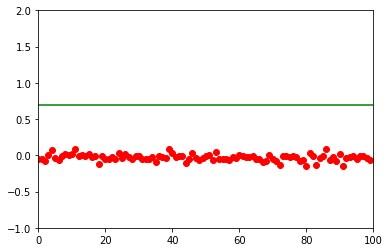

The PSIS-LOO value for model  1 Categories  is  -371.6301800196023

 k-values plotted


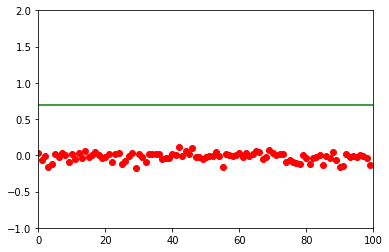

The PSIS-LOO value for model  2 All  is  -354.74865953339565

 k-values plotted


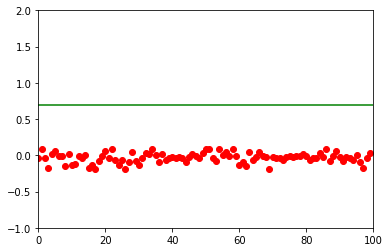

The PSIS-LOO value for model  2 Catergories  is  -372.1525282751101

 k-values plotted


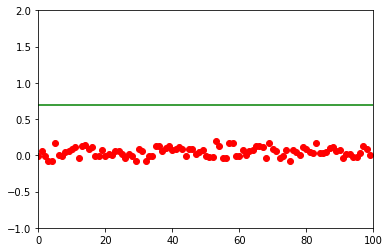

The PSIS-LOO value for model  3 All  is  -356.60604661080697

 k-values plotted


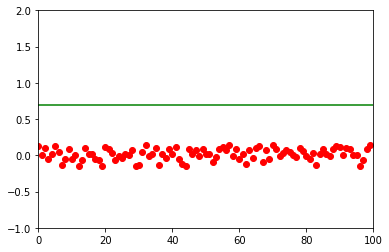

The PSIS-LOO value for model  3 Categories  is  -371.4137850614654

 k-values plotted


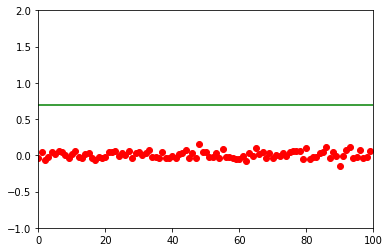

The PSIS-LOO value for model  4 All  is  -350.8026854902713

 k-values plotted


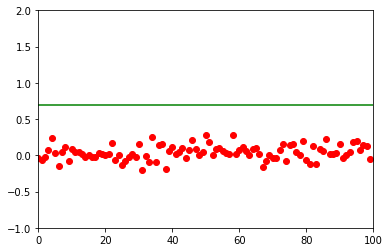

The PSIS-LOO value for model  4 Catergories  is  -369.8204074167011

 k-values plotted


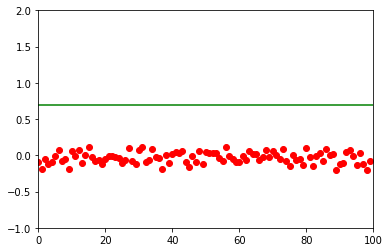

In [372]:

samples = [samples_1_all,samples_1_cat,samples_2_all,samples_2_cat,samples_3_all,samples_3_cat,samples_4_all,samples_4_cat]
sample_names = ["1 All","1 Categories","2 All","2 Catergories","3 All","3 Categories","4 All","4 Catergories"]

i = 0
for sample in samples:
    
    loo, loos, ks = psisloo(sample['log_lik'])
    print("The PSIS-LOO value for model ",sample_names[i]," is ",loo)
    print("\n k-values plotted")
    plt.plot(ks,'ro')
    plt.axis([0, 100, -1, 2])
    plt.axhline(0.7, color='g')
    plt.show();
    i += 1

## Results and Conclusion

Based on the above, the best model seems to the fourth model ran with all the data as the PSIS-LOO value is the lowest and the k values are all under the 0.7 threshold.

Although let's first analyze and interpret the drawn parameter values from our selected model. First, let's plot the histograms of the parameters of the values $b$ and $c$ that will affect the inserted data used in our selected model.

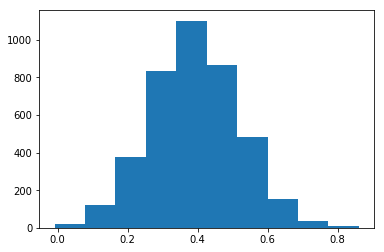

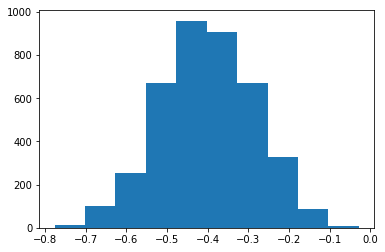

In [388]:
a = samples_4_all['a']
b = samples_4_all['b']
c = samples_4_all['c']
plt.hist(b)
plt.show()
plt.hist(c)
plt.show();

As in our discussion when selecting the priors, all the values for $b$ are positive meaning more supporters means a higher probability. Also all the values for $c$ are negative meaning that a higher goal will decrease the probability of success. Although now the question remains how relevant are the parameters in predicting success given certain data. The values are hard to interpret intuitively since the data was inserted into the model in logistic scale.

Let's plot a few histograms for needed backer count given a few goal sizes and an 80% chance of success:
* How many backers should we have for a project with a goal of USD 1000
* How many backers should we have for a project with a goal of USD 10000
* How many backers should we have for a project with a goal of USD 100000

We'll calculate the needed amount of backers as follows from the posterior draws:

Our model for $θ$: $logit(θ) = a + bs + cg$,
from which we ca draw that $θ = logit^{-1}(a + bs + cg) = 0.8$
and again that $s = (log(0.8/0.2) - cg -a)/b$

Finally, we also need to exponentiate $s$ back to non logistic scale before we plot the histogram.

Histogram of backers needed for first project


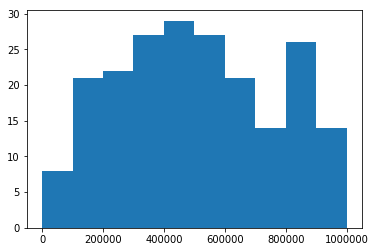

Histogram of backers needed for second project


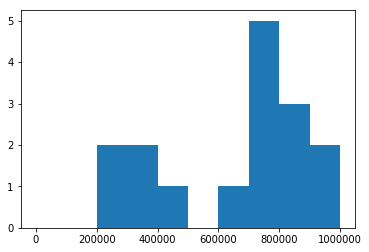

Histogram of backers needed for third project


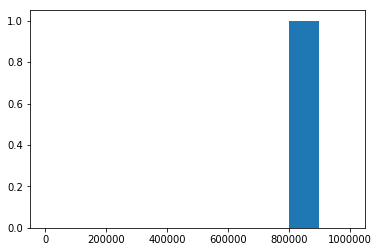

In [431]:
g1 = np.log(1000)
s = (np.log(0.8/0.2)-c*g1-a)/b
s_exp = np.exp(s)
plt.hist(s_exp,range=(20,1000000))
print("Histogram of backers needed for first project")
plt.show();

g2 = np.log(10000)
s = (np.log(0.8/0.2)-c*g2-a)/b
s_exp = np.exp(s)
plt.hist(s_exp,range=(20,1000000))
print("Histogram of backers needed for second project")
plt.show();

g3 = np.log(100000)
s = (np.log(0.8/0.2)-c*g3-a)/b
s_exp = np.exp(s)
plt.hist(s_exp,range=(20,1000000))
print("Histogram of backers needed for third project")
plt.show();

We can see that for all projects the needed backer count in the scale from 20 (our minimum interesting threshold) and 1 000 000 (realistic?) the needed backer count is in the hundreds of thousands, leading us to the conclusion that the selected model does not work well in practice and the drawn values from the posterior can be interpreted to have little effect in predicting probability of success in different projects.

Therefore we can't use the above methodology to help guide in the decision making for our project. It looks like optimizing the available paramaters (average backer size, price, or goal) can't directly make us successful. It remains to be found out beyond this project whether some optimal model can be fit into the data to make predctions. For now we would suggest making decisions based on the means of the successful projets in the Fashion and Apparel category:

In [438]:
print("Mean of the amount of backers for successful Fashion / Apparel projects: ", "%.0f" % suc_mean_back)
print("Mean of the goal for successful Fashion / Apparel projects: ", "%.0f" % suc_mean_goal)
print("Mean of the pledged amount of backers for successful Fashion / Apparel projects: ", "%.0f" % suc_mean_pled)

Mean of the amount of backers for successful Fashion / Apparel projects:  226
Mean of the goal for successful Fashion / Apparel projects:  10923
Mean of the pledged amount of backers for successful Fashion / Apparel projects:  24148


## Problems and improvement ideas
To be able to draw meaningful conclusions for future Kickstarter projects, two approaches should be tried:
* Find different data for the projects such as review grades from users (if available). The current data does not seem to reveal any clear correlations with the chosen parameters (price, average backer size, goal)
* Try out different models besides the family of multi parameter linear models tried here. One challenge with the particular problem is that more complex models can easily be made, but the interpretation based on the posterior might be challenging (for example when using both the goal and pledged amount in the model)

## Appendix
PSIS-LOO function:

In [435]:
"""Pareto smoothed importance sampling (PSIS)
This module implements Pareto smoothed importance sampling (PSIS) and PSIS
leave-one-out (LOO) cross-validation for Python (Numpy).
Included functions
------------------
psisloo
    Pareto smoothed importance sampling leave-one-out log predictive densities.
psislw
    Pareto smoothed importance sampling.
gpdfitnew
    Estimate the paramaters for the Generalized Pareto Distribution (GPD).
gpinv
    Inverse Generalised Pareto distribution function.
sumlogs
    Sum of vector where numbers are represented by their logarithms.
References
----------
Aki Vehtari, Andrew Gelman and Jonah Gabry (2017). Practical
Bayesian model evaluation using leave-one-out cross-validation
and WAIC. Statistics and Computing, 27(5):1413–1432.
doi:10.1007/s11222-016-9696-4. https://arxiv.org/abs/1507.04544
Aki Vehtari, Andrew Gelman and Jonah Gabry (2017). Pareto
smoothed importance sampling. https://arxiv.org/abs/arXiv:1507.02646v5
"""

from __future__ import division # For Python 2 compatibility
import numpy as np

# 3-Clause BSD License
"""
Copyright 2017 Aki Vehtari, Tuomas Sivula
Redistribution and use in source and binary forms, with or without modification,
are permitted provided that the following conditions are met:
1. Redistributions of source code must retain the above copyright notice, this
list of conditions and the following disclaimer.
2. Redistributions in binary form must reproduce the above copyright notice,
this list of conditions and the following disclaimer in the documentation and/or
other materials provided with the distribution.
3. Neither the name of the copyright holder nor the names of its contributors
may be used to endorse or promote products derived from this software without
specific prior written permission.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR
ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON
ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. """


def psisloo(log_lik, **kwargs):
    r"""PSIS leave-one-out log predictive densities.
    Computes the log predictive densities given posterior samples of the log
    likelihood terms :math:`p(y_i|\theta^s)` in input parameter `log_lik`.
    Returns a sum of the leave-one-out log predictive densities `loo`,
    individual leave-one-out log predictive density terms `loos` and an estimate
    of Pareto tail indeces `ks`. The estimates are unreliable if tail index
    ``k > 0.7`` (see more in the references listed in the module docstring).
    Additional keyword arguments are passed to the :meth:`psislw()` function
    (see the corresponding documentation).
    Parameters
    ----------
    log_lik : ndarray
        Array of size n x m containing n posterior samples of the log likelihood
        terms :math:`p(y_i|\theta^s)`.
    Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities
    loos : ndarray
        individual leave-one-out log predictive density terms
    ks : ndarray
        estimated Pareto tail indeces
    """
    # ensure overwrite flag in passed arguments
    kwargs['overwrite_lw'] = True
    # log raw weights from log_lik
    lw = -log_lik
    # compute Pareto smoothed log weights given raw log weights
    lw, ks = psislw(lw, **kwargs)
    # compute
    lw += log_lik
    loos = sumlogs(lw, axis=0)
    loo = loos.sum()
    return loo, loos, ks


def psislw(lw, Reff=1.0, overwrite_lw=False):
    """Pareto smoothed importance sampling (PSIS).
    Parameters
    ----------
    lw : ndarray
        Array of size n x m containing m sets of n log weights. It is also
        possible to provide one dimensional array of length n.
    Reff : scalar, optional
        relative MCMC efficiency ``N_eff / N``
    overwrite_lw : bool, optional
        If True, the input array `lw` is smoothed in-place, assuming the array
        is F-contiguous. By default, a new array is allocated.
    Returns
    -------
    lw_out : ndarray
        smoothed log weights
    kss : ndarray
        Pareto tail indices
    """
    if lw.ndim == 2:
        n, m = lw.shape
    elif lw.ndim == 1:
        n = len(lw)
        m = 1
    else:
        raise ValueError("Argument `lw` must be 1 or 2 dimensional.")
    if n <= 1:
        raise ValueError("More than one log-weight needed.")

    if overwrite_lw and lw.flags.f_contiguous:
        # in-place operation
        lw_out = lw
    else:
        # allocate new array for output
        lw_out = np.copy(lw, order='F')

    # allocate output array for kss
    kss = np.empty(m)

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(0.2 * n, 3 * np.sqrt(n / Reff)))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    logn = np.log(n)
    k_min = 1/3

    # loop over sets of log weights
    for i, x in enumerate(lw_out.T if lw_out.ndim == 2 else lw_out[None, :]):
        # improve numerical accuracy
        x -= np.max(x)
        # sort the array
        x_sort_ind = np.argsort(x)
        # divide log weights into body and right tail
        xcutoff = max(
            x[x_sort_ind[cutoff_ind]],
            cutoffmin
        )
        expxcutoff = np.exp(xcutoff)
        tailinds, = np.where(x > xcutoff)
        x2 = x[tailinds]
        n2 = len(x2)
        if n2 <= 4:
            # not enough tail samples for gpdfitnew
            k = np.inf
        else:
            # order of tail samples
            x2si = np.argsort(x2)
            # fit generalized Pareto distribution to the right tail samples
            np.exp(x2, out=x2)
            x2 -= expxcutoff
            k, sigma = gpdfitnew(x2, sort=x2si)
        if k >= k_min and not np.isinf(k):
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, n2)
            sti /= n2
            qq = gpinv(sti, k, sigma)
            qq += expxcutoff
            np.log(qq, out=qq)
            # place the smoothed tail into the output array
            x[tailinds[x2si]] = qq
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
        # renormalize weights
        x -= sumlogs(x)
        # store tail index k
        kss[i] = k

    # If the provided input array is one dimensional, return kss as scalar.
    if lw_out.ndim == 1:
        kss = kss[0]

    return lw_out, kss


def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)
    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.
    Parameters
    ----------
    x : ndarray
        One dimensional data array
    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.
    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).
    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.
    Returns
    -------
    k, sigma : float
        estimated parameter values
    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.
    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.
    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:,None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:,None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        return k, sigma, ks, w
    else:
        return k, sigma


def gpinv(p, k, sigma):
    """Inverse Generalised Pareto distribution function."""
    x = np.empty(p.shape)
    x.fill(np.nan)
    if sigma <= 0:
        return x
    ok = (p > 0) & (p < 1)
    if np.all(ok):
        if np.abs(k) < np.finfo(float).eps:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            np.negative(x, out=x)
        else:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            x *= -k
            np.expm1(x, out=x)
            x /= k
        x *= sigma
    else:
        if np.abs(k) < np.finfo(float).eps:
            # x[ok] = - np.log1p(-p[ok])
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            np.negative(temp, out=temp)
            x[ok] = temp
        else:
            # x[ok] = np.expm1(-k * np.log1p(-p[ok])) / k
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            temp *= -k
            np.expm1(temp, out=temp)
            temp /= k
            x[ok] = temp
        x *= sigma
        x[p == 0] = 0
        if k >= 0:
            x[p == 1] = np.inf
        else:
            x[p == 1] = -sigma / k
    return x


def sumlogs(x, axis=None, out=None):
    """Sum of vector where numbers are represented by their logarithms.
    Calculates ``np.log(np.sum(np.exp(x), axis=axis))`` in such a fashion that
    it works even when elements have large magnitude.
    """
    maxx = x.max(axis=axis, keepdims=True)
    xnorm = x - maxx
    np.exp(xnorm, out=xnorm)
    out = np.sum(xnorm, axis=axis, out=out)
    if isinstance(out, np.ndarray):
        np.log(out, out=out)
    else:
        out = np.log(out)
    out += np.squeeze(maxx)
    return out